### ISC CamCan Suspense

The goal of this notebook is to perform supplementary analyses.

In particular, beyond the main analysis reported in the paper, we compute

1) a pure activation analysis (as opposed to ISC)

2) a mixed ISC+activation analysis

3) an analysis of brain-state patterns (point-patterns, or spatial ISC)

4) a control analysis of ISC on motion data

5) a control analysis of ISC on resting state data

### setting up modules

In [1]:
import numpy as np
import os, sys, scipy, nilearn, warnings#, #brainiak
import nibabel as nib
from nilearn import plotting, input_data
from nilearn.input_data import NiftiLabelsMasker
import seaborn as sns
import pandas as pd
warnings.filterwarnings("ignore")
#from brainiak import isfc
from camcan_utils import *

from scipy import stats
#import tables as tb         # PyTables library does on disk (i.e. bigger than memory matrices storage)
import matplotlib.pyplot as plt
%matplotlib inline

/Users/Ralf/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### set up files

In [2]:
suspense_file         = '../data/avg_suspense.npy'
dict_file             = '../data/timeseries_dictionary.npy'
dyn_isc_file          = '../data/dyn_isc_dict.npy'
shen_dictionary_file  = '../data/shen_dictionary.npy'
shen_atlas_filename   =  '../data/shen_2mm_268_parcellation.nii'
sample_file           =  '../data/func.nii'

### load data 

In [3]:
# load the dynamic isc results (precomputed and stored in notebook03 to save time)
dyn_isc_dict = np.load(dyn_isc_file).item() 
dyn_isc_result_all = dyn_isc_dict['dyn_isc_result_all']
dyn_isc_result = dyn_isc_dict['dyn_isc_result_splithalf']
del dyn_isc_dict

shen_dictionary = np.load('../data/shen_dictionary.npy').item()
shen_dictionary[15] #15->14 because of zero-indexing ...

{'coords': [6.80707395498392, 21.446945337620576, 31.40836012861736],
 'name': '58.36% Cingulate_Gyrus_anterior_division; 41.00% Paracingulate_Gyrus'}

In [4]:
# read in the time series data to get access to the raw BOLD activation values 
read_dictionary = np.load(dict_file).item()

subjs = list(read_dictionary.keys())
n_subjs = len(subjs)
n_tr, n_regions = read_dictionary[subjs[0]]['funcdata'].shape
n_tr_rest, n_regions = read_dictionary[subjs[0]]['funcdata_rest'].shape

ts_data = np.zeros((n_tr, n_regions, n_subjs))
ts_data_undet = np.zeros((n_tr, n_regions,n_subjs))
motion_data = np.zeros((n_tr, 6, n_subjs))

rest_list = [] 
#re-create ts_data
for curr_sub in range(n_subjs):
    curr_sub_name                = subjs[curr_sub]
    ts_data[:,:, curr_sub]       = read_dictionary[curr_sub_name]['funcdata']
    ts_data_undet[:,:, curr_sub] = read_dictionary[curr_sub_name]['funcdata_unfilt_undet_stand']
    motion_data[:,:, curr_sub]   = read_dictionary[curr_sub_name]['motion']
    if np.asarray(read_dictionary[curr_sub_name]['funcdata_rest']).shape == (n_tr_rest, n_regions):
        rest_list.append(read_dictionary[curr_sub_name]['funcdata_rest'])
        #things are a bit cumbersome for the resting state data because - due to artifact control etc, different subjects pass the threshold
        

ts_data_rest = np.asarray(rest_list)
ts_data_rest = np.swapaxes(ts_data_rest, 0,2)
ts_data_rest = np.swapaxes(ts_data_rest, 0,1)
del rest_list, read_dictionary

### compare ISC and raw (activation) results

In [6]:
# compute mean for aMCC
vals1 = np.nanmean(ts_data_undet[:, 14, :248], axis=1)
vals2 = np.nanmean(ts_data_undet[:, 14, 248:], axis=1) #248 -> to take average from half of the group

# compute a rolling average as well
roll_vals1 = pd.DataFrame(vals1).rolling(window = 5, center = True, win_type = 'boxcar', min_periods = 0).mean()[0].values
roll_vals2 = pd.DataFrame(vals2).rolling(window = 5, center = True, win_type = 'boxcar', min_periods = 0).mean()[0].values

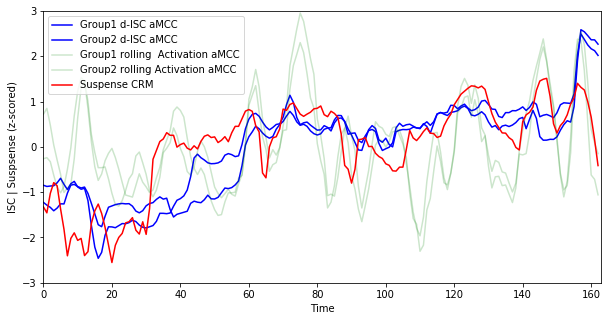

In [7]:
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(111)


ax1.plot(scipy.stats.zscore(dyn_isc_result[0,14,:]), 
         color = 'blue', label = 'Group1 d-ISC aMCC');

ax1.plot(scipy.stats.zscore(dyn_isc_result[1,14,:]), 
         color = 'blue', label = 'Group2 d-ISC aMCC');

ax1.plot(scipy.stats.zscore(scipy.signal.resample(roll_vals1, 163)) , 
         color = 'green', alpha = 0.2, label = 'Group1 rolling  Activation aMCC');

ax1.plot(scipy.stats.zscore(scipy.signal.resample(roll_vals2, 163)) , 
         color = 'green', alpha = 0.2, label = 'Group2 rolling Activation aMCC');

suspense = np.load(suspense_file)
ax1.plot(scipy.signal.resample(scipy.stats.zscore(suspense), 163), color = 'red', label = 'Suspense CRM');

plt.legend(loc = 'upper left')
plt.xlim(0, 163)
plt.ylim(-3, 3)
plt.xlabel('Time');
plt.ylabel('ISC | Suspsense (z-scored)');

As can be seen, the aMCC activation values are related to suspense in the sense that during peak-suspense, there is strong activation, but there are also activations in the beginning of the movie, and the activations are less well aligned with the suspense-CRM.

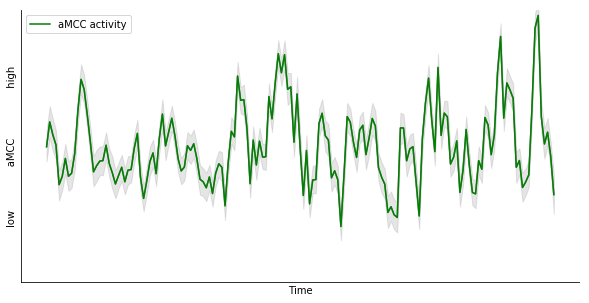

In [8]:
red_data = ts_data_undet[:, 14, :].T
d = []
for f in range (red_data.shape[0]):
    d.append(scipy.signal.resample(scipy.stats.zscore(red_data[f,:]), 163))
stacked_acc = np.asarray(d)

d = np.hstack(stacked_acc)
h = np.hstack([np.arange(163)] * red_data.shape[0])
dh = np.vstack((d,h)).T
df_dh = pd.DataFrame(data =  dh, columns = ['a','b'])

f = plt.figure(figsize=(10,5));
sns.lineplot(x="b", y="a", color = 'gray', data=df_dh);
plt.plot(np.mean(stacked_acc, axis = 0), color ='green', label = 'aMCC-BOLD activity');
plt.ylabel('low                aMCC-BOLD                high');
plt.xlabel('Time');
plt.ylim(-0.8, 0.8);
plt.xticks([]);
plt.yticks([]);
plt.legend();
sns.despine();

### create combination of ISC and raw data 

We can thus try to e.g. create a combined processing and activation measure, i.e. by multiplying the dynamic ISC with the current activation values.

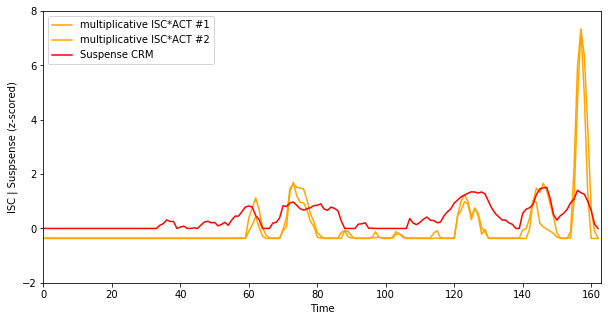

In [9]:
# get the dynamic ISC and activation data for subgroups
isc1 = scipy.stats.zscore(dyn_isc_result[0,14,:])
isc2 = scipy.stats.zscore(dyn_isc_result[1,14,:])
act1 = scipy.stats.zscore(scipy.signal.resample(roll_vals1, 163))  
act2 = scipy.stats.zscore(scipy.signal.resample(roll_vals2, 163)) 

# if either one is below average, set the one of the multiplicands to zero
act1[act1<0] = 0
act2[act2<0] = 0
isc1[isc1<0] = 0
isc2[isc2<0] = 0

# multiply the isc and the activation. Thus, if either is low, product will be low, if both are high, product will be high
mult1 = scipy.stats.zscore((act1 * isc1))
mult2 = scipy.stats.zscore((act2 * isc2))


f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(111)

ax1.plot(mult1, color = 'orange', label = 'multiplicative ISC*ACT #1');
ax1.plot(mult2, color = 'orange', label = 'multiplicative ISC*ACT #2');
susp1 = scipy.signal.resample(scipy.stats.zscore(suspense), 163)
susp1[susp1<0]= 0 #np.nan
ax1.plot(susp1, color = 'red', label = 'Suspense CRM');

plt.legend(loc = 'upper left');
plt.xlim(0, 163);
plt.ylim(-2, 8);
plt.xlabel('Time');
plt.ylabel('ISC | Suspsense (z-scored)');

this analysis poses the interesting question: might people who turn their dials actually be no longer able to 
increase their scores because they maxed them out earlier? It is well known (e.g. Psychophysics) that rating data are inherently relative and people respond more to changes than they are able to report direct magnitudes/numbers. Here, by asking the brain, there seems a possibility to get a purer measure (although this one will have similar range limitations as well at some point).

### compute pattern-based results

an alternative to isc, which measures the temporal reliability of a neural process, is to computer a pattern-isc.
Thus, instead of computing correlations over time, we compute them across space. In this case, we measure the similarity of the brain-state at a given moment in time, i.e. whether different brains are 'standing in a similar posture' (such as activated ACC, de-activated visual cortex, medium-level amygdala). The advantage of this measure is that we can resolve it in time (get one value per TR), but we lose all spatial information (get only one value for the entire brain). Of note variants of this analysis could be done via searchlight analysis.

In [40]:
ts_vox_time_data = np.swapaxes(ts_data[:,:,:], 0,1)  
pattern_isc_result_all = camcan_isc(ts_vox_time_data, summary_statistic=np.mean, verbose = False)

ts_vox_time_data = np.swapaxes(ts_data[:,:,:248], 0,1)  ### change to e.g. 50 or so to speed up
pattern_isc_result1 = camcan_isc(ts_vox_time_data, summary_statistic=np.mean, verbose = False)

ts_vox_time_data = np.swapaxes(ts_data[:,:,248:], 0,1)
pattern_isc_result2 = camcan_isc(ts_vox_time_data, summary_statistic=np.mean, verbose = False)

pattern_isc_result_all_z = np.squeeze(scipy.stats.zscore(pattern_isc_result_all.T))
pattern_isc_result1_z = np.squeeze(scipy.stats.zscore(pattern_isc_result1.T))
pattern_isc_result2_z = np.squeeze(scipy.stats.zscore(pattern_isc_result2.T))

#np.save('../data/pattern_isc_result_all_z.npy', pattern_isc_result_all_z)

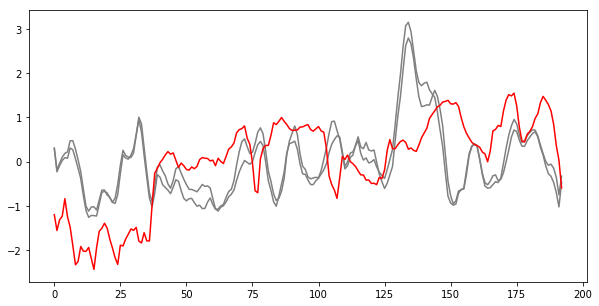

In [41]:
suspense_raw = '../data/suspense.npy'
all_suspense = np.load(suspense_raw)
all_suspense = all_suspense[:,50:2440] 
ms = np.mean(all_suspense, axis=0)
ms193 = scipy.signal.resample(ms, 193)

f = plt.figure(figsize=(10,5))
rolling_pattern_isc_result1_z = pd.DataFrame(pattern_isc_result1_z).rolling(window = 5, center = False, win_type = 'boxcar', min_periods = 0).mean()[0].values
rolling_pattern_isc_result2_z = pd.DataFrame(pattern_isc_result2_z).rolling(window = 5, center = False, win_type = 'boxcar', min_periods = 0).mean()[0].values

plt.plot(rolling_pattern_isc_result1_z, color = 'gray');
plt.plot(rolling_pattern_isc_result2_z, color = 'gray');

#plt.plot(pattern_isc_result1_z, color = 'orange')
#plt.plot(pattern_isc_result2_z, color = 'orange')

plt.plot(scipy.stats.zscore(ms193), color = 'red'); 

In [42]:
np.corrcoef(ms193, pattern_isc_result_all_z)[0,1]

0.1791897539011955

what does the peak mean? It is very reliable, suggesting that there is something happening that induces a very stable brain-pattern. 

There is some alignment here (r = 0.18 between the pattern-vector and the ms193), but overall the whole-brain pattern does not seem to track with suspense so much.

0.8218583958966665

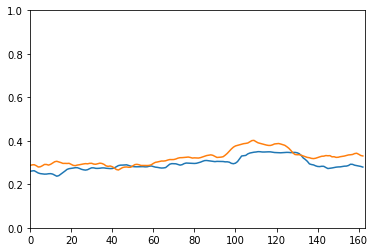

In [44]:
#plt.plot(scipy.signal.resample(pattern_isc_result_all, 163))
#plt.plot(dyn_isc_result_all[37,:]);
#plt.plot(dyn_isc_result_all[14,:]);
dyn_mean = np.nanmean(dyn_isc_result_all[:,:], axis =0)
plt.plot(dyn_mean);

roll_pattern = pd.DataFrame(scipy.signal.resample(pattern_isc_result_all.T, 163)).rolling(window = 30, center = True, win_type = 'boxcar', min_periods = 0).mean()[0].values
plt.plot(roll_pattern)
plt.xlim(0,163)
plt.ylim(0,1)

np.corrcoef(dyn_mean, roll_pattern)[0,1] 

interesting to note that the dynamic ISC (temporal ISC per region, then averaged across the regions) and the rolling-mean of the pattern ISC (pattern-correlations per TR, then smoothed out over TRs.) are highly correlated. more work is needed to zoom in on this

### compute ISC on confounds

In [45]:
D = motion_data
print('Calculating ISC on ', D.shape[1], ' regions/variables and ', D.shape[2], ' subjects')
motionISC = camcan_isc(D, summary_statistic=np.mean, verbose = False)
motionISC

Calculating ISC on  6  regions/variables and  494  subjects


array([[0.07457255, 0.14208735, 0.03709491, 0.1700848 , 0.05871671,
        0.32475311]])

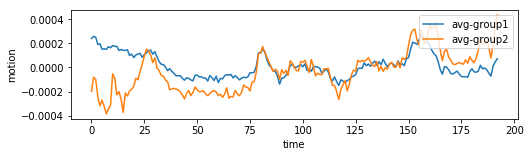

0.33584941959643


In [47]:
i = 2
m1mean = np.nanmean(motion_data[:,i,:248], axis = 1)
m2mean = np.nanmean(motion_data[:,i,248:], axis = 1)

f = plt.figure(figsize=(8,2))
plt.plot((m1mean), label = 'avg-group1');
plt.plot((m2mean), label = 'avg-group2');
plt.xlabel('time');
plt.ylabel('motion');
plt.legend(loc = 1)
plt.show()

print(np.corrcoef(m1mean, m2mean)[0,1])
# pretty surprising how reliable motion can be - at least in part.
# note that this is residual motion after pretty strict thresholding (see extraction notebook)
# however, it is considerably lower than the brain-ISC (see main ISC notebook where such group-averaged 
# timeseries are nearly 1 in all regions)

In [49]:
motion_data.shape[0]

193

In [51]:
winSize = 30
step = 1
numOfChunks = int((n_tr - winSize)/step ) 
print(numOfChunks)

# set up sub-samples
subject_chunks = [[0, int(n_subjs/2)],
                  [int(n_subjs/2), n_subjs]]
n_iterations = len(subject_chunks)
dyn_motion_isc_result = np.zeros((n_iterations, motion_data.shape[1], numOfChunks))

sub_index = np.arange(n_subjs)
np.random.shuffle(sub_index)

for curr_sample in range(n_iterations): 
    print('Working on ', (curr_sample +1 ), ' of ', n_iterations)
    people_to_use = np.arange(subject_chunks[curr_sample][0], subject_chunks[curr_sample][1], 1)
    #print(people_to_use)
    #print(sub_index[people_to_use])
    
    D = motion_data[:,:,sub_index[people_to_use] ]
    print('Calculating motionISC on ', D.shape[0], ' voxels/regions and ', D.shape[2], ' subjects over ', numOfChunks, ' windows.'   )
    
    slide_isc_node_seg_mean = np.zeros((motion_data.shape[1],numOfChunks))
    onsets = np.arange(0,numOfChunks*step, step)  
    
    for curr_win in range(0,numOfChunks):    
        #print(curr_win)
        this_onset = onsets[curr_win]
        D_seg_data = D[this_onset:(this_onset+winSize), :, :]
        ISC = camcan_isc(D_seg_data, summary_statistic=np.mean, verbose = False)
        ISC[np.isnan(ISC)] = 0
        slide_isc_node_seg_mean[:, curr_win] = ISC 

        progress = 100 * ( curr_win/numOfChunks)
        sys.stdout.write("\r%d%%" % progress)
        sys.stdout.flush()

    dyn_motion_isc_result[curr_sample, :, :] = slide_isc_node_seg_mean
    

163
Working on  1  of  2
Calculating motionISC on  193  voxels/regions and  247  subjects over  163  windows.
99%Working on  2  of  2
Calculating motionISC on  193  voxels/regions and  247  subjects over  163  windows.
99%

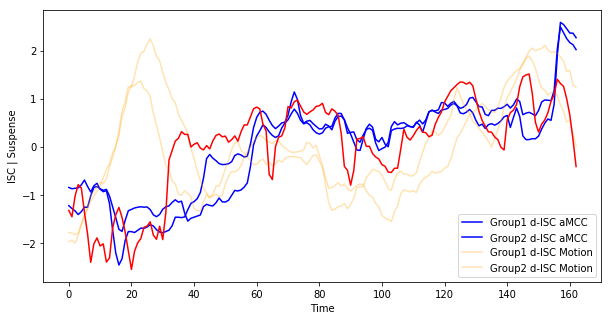

In [54]:
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(111)

ax1.plot(scipy.stats.zscore(dyn_isc_result[0,14,:]), 
         color = 'blue', label = 'Group1 d-ISC aMCC');
ax1.plot(scipy.stats.zscore(dyn_isc_result[1,14,:]), 
         color = 'blue', label = 'Group2 d-ISC aMCC');

ax1.plot(scipy.stats.zscore(np.mean(dyn_motion_isc_result[0,:,:], axis=0).T), 
         alpha = 0.3, color = 'orange', label = 'Group1 d-ISC Motion');
ax1.plot(scipy.stats.zscore(np.mean(dyn_motion_isc_result[1,:,:], axis=0).T), 
         alpha = 0.3, color = 'orange', label = 'Group2 d-ISC Motion');

ax1.plot(scipy.signal.resample(scipy.stats.zscore(suspense), 163), color = 'red');
plt.legend();
plt.xlabel('Time');
plt.ylabel('ISC | Suspense');

Conclusion: Motion is not very high and does not seem to drive the results.

Interestingly, there is quite a bit of motion-ISC - although it is much lower than the brain-level ISC. Of note, the fact that I heavily censored high-motion subjects so that they don't enter the analysis will underestimate the amount of motion in the full dataset (i.e. 646 participants instead of the 496 with low motion)

Nevertheless, more work is needed to look into synchronized motion

### ISC on resting state data

In [55]:
ts_data_rest.shape

(261, 268, 405)

In [58]:
D_rest = ts_data_rest[50:, :, :] #we do this because there is apparently a strong transient in the resting state data.
# this may be due to subjects being instructed to close their eyes after the start of the scan or similar factor
# if you want to look at the data at this stage, you ...

#rest
print('Calculating ISC on ', D_rest.shape[1], ' voxels/regions and ', D_rest.shape[2], ' subjects')
ISC_rest = camcan_isc(D_rest, summary_statistic=np.mean, verbose = False)
ISC_rest[np.isnan(ISC_rest)] = 0

Calculating ISC on  268  voxels/regions and  405  subjects


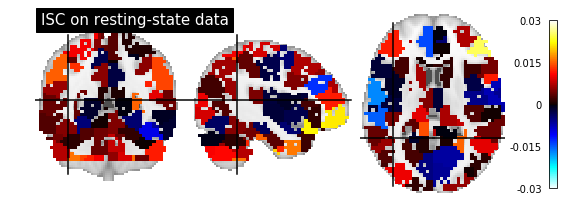

In [59]:
# need to re-fit the masker first to be able to plot results
shen_masker = NiftiLabelsMasker(labels_img=shen_atlas_filename);
shen_masker.fit_transform(sample_file);

#isc_rest_vector = np.reshape(ISC_rest, (1,n_regions));
res_img_rest = shen_masker.inverse_transform(ISC_rest);
nilearn.plotting.plot_stat_map(nilearn.image.index_img(res_img_rest,0), 
                                   draw_cross = True,
                                   cut_coords = (-40,-50,10),
                                   annotate = False,
                                   title = 'ISC on resting-state data');

Calculating ISC on  193  voxels/regions and  494  subjects


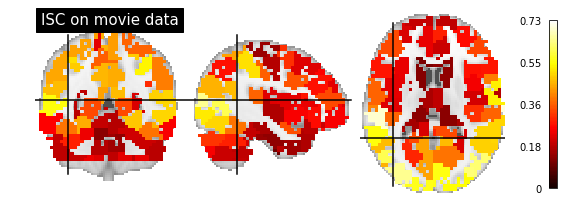

In [60]:
#movie
D = ts_data[:,:,:]
print('Calculating ISC on ', D.shape[0], ' voxels/regions and ', D.shape[2], ' subjects')
ISC = camcan_isc(D, summary_statistic=np.mean, verbose = False)
ISC[np.isnan(ISC)] = 0

#isc_vector = np.reshape(ISC, (1,n_regions));
res_img = shen_masker.inverse_transform(ISC);
nilearn.plotting.plot_stat_map(nilearn.image.index_img(res_img,0), 
                                   draw_cross = True,
                                   cut_coords = (-40,-50,10),
                                   annotate = False,
                                   title = 'ISC on movie data');

Summary: As expected, there is no ISC during resting state, but the movie 'syncs up' the brains of the audience.

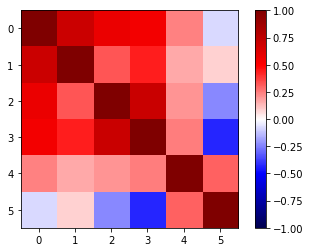

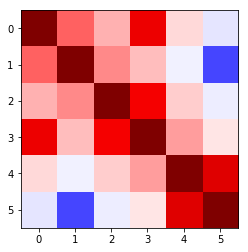

In [229]:
plt.imshow(np.corrcoef(dyn_motion_isc_result[0,:,:]), cmap= 'seismic', vmin =-1., vmax=1)
plt.colorbar()
plt.show()
plt.imshow(np.corrcoef(dyn_motion_isc_result[1,:,:]), cmap= 'seismic', vmin =-1., vmax=1)